Reduced MNIST Tutorial : take a pre-trained network as a feature extractor and train a classifier on it

THALES DMS France, 2019, Atelier ALLOHA du 15/01/2019

Import lib

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras import applications
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from PIL import Image
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

/home/user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Database

In [2]:
# load mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reduce dataset size
n_train, img_height, img_width = x_train.shape
n_train = 400
x_train.shape
x_train = x_train[:n_train,:,:]
y_train = y_train[:n_train]
n_test = 800
x_test = x_test[:n_test,:,:]
y_test = y_test[:n_test]

num_classes = np.max(y_train)+1
y_train_class = to_categorical(y_train,num_classes=num_classes)
y_test_class = to_categorical(y_test,num_classes=num_classes)

# resize images
img_width, img_height = 48, 48
x_train_r = np.zeros((n_train, img_height, img_width))
x_test_r = np.zeros((n_test, img_height, img_width))
for row in range(n_train):
    x_train_r[row,:,:] = np.array(Image.fromarray(x_train[row,:,:]).resize((img_height,img_width),Image.ANTIALIAS))
for row in range(n_test):
    x_test_r[row,:,:] = np.array(Image.fromarray(x_test[row,:,:]).resize((img_height,img_width),Image.ANTIALIAS))

# duplicate on 3 channels
x_train = np.zeros((n_train, img_height, img_width, 3))
x_test = np.zeros((n_test, img_height, img_width, 3))
x_train[:,:,:,0] = x_train_r/1.0
x_train[:,:,:,1] = x_train_r/1.0
x_train[:,:,:,2] = x_train_r/1.0
x_test[:,:,:,0] = x_test_r/1.0
x_test[:,:,:,1] = x_test_r/1.0
x_test[:,:,:,2] = x_test_r/1.0
    
x_train.shape, x_test.shape

((400, 48, 48, 3), (800, 48, 48, 3))

Images dimensions

In [3]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Training parameters

In [4]:
epochs = 50
batch_size = 16
top_model_weights_path = 'bottleneck_fc_model.h5'

Function for computing VGG16 features of the database images

In [5]:
def save_bottlebeck_features():
    
    # VGG16 network without fully-connected layers
    input_tensor = Input(shape=input_shape)
    model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Compute and save VGG16 features of the training database images
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    generator = train_datagen.flow(
        x_train,
        y_train_class,
        batch_size=batch_size,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, len(generator))
    bottleneck_features_train = bottleneck_features_train[:n_train]
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    # Compute and save VGG16 features of the test database images
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    generator = test_datagen.flow(
        x_test,
        y_test_class,
        batch_size=batch_size,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, len(generator))
    bottleneck_features_validation = bottleneck_features_validation[:n_test]
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

Function for training a dense neural network on computed VGG16 features of the database images

In [6]:
def train_top_model_nn():
    
    # Load VGG16 features of the training database images
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    
    # Load VGG16 features of the test database images and associated labels
    validation_data = np.load(open('bottleneck_features_validation.npy','rb'))

    # Neural Network
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compiler
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    # Training
    history = model.fit(train_data, y_train_class,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, y_test_class))
    # Plot
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # Save Network weights
    model.save_weights(top_model_weights_path)

Function for training a SVM on computed VGG16 features of the database images

In [12]:
def train_top_model_SVM():
    
    # Load VGG16 features of the training database images and associated labels
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    train_data = np.reshape(train_data,(train_data.shape[0], train_data.shape[1]*train_data.shape[2]*train_data.shape[3]))
    
    # Load VGG16 features of the test database images and associated labels
    validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
    validation_data = np.reshape(validation_data,(validation_data.shape[0], validation_data.shape[1]*validation_data.shape[2]*validation_data.shape[3]))
    
    # Brute force approach : train multiple SVM with various parameter settings
    C_test = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
    gamma_test = [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    acc_max = 0
    c0 = 0.000001
    g0 = 0.00000001
    for c in C_test:
        for g in gamma_test:
            svc = SVC(kernel='rbf', C=c, gamma=g)
            svc.fit(train_data, y_train)
            restrain_tmp = svc.score(train_data, y_train)
            res_tmp = svc.score(validation_data, y_test)
            print(["Precision SVM courante :"+" acc = "+str(100*restrain_tmp)+" acc_val = "+str(100*res_tmp)+" C = "+str(c)+" gamma = "+str(g)])
            if (100.0*res_tmp>acc_max):
                c0 = c
                g0 = g
                acc_max = 100.0*res_tmp
                
    
    svc = SVC(kernel='rbf', C=c0, gamma=g0)
    svc.fit(train_data, y_train)
    score = svc.score(validation_data, y_test)
    print(["Precision SVM maximale : "+str(100.0*score)])

Compute VGG16 features of the database images

In [8]:
save_bottlebeck_features()

Train dense neural network on computed VGG16 features of the database images

Train on 400 samples, validate on 800 samples
Epoch 1/50
400/400 [==============================] - 0s 415us/step - loss: 11.2974 - acc: 0.1475 - val_loss: 8.1144 - val_acc: 0.3125
Epoch 2/50
400/400 [==============================] - 0s 92us/step - loss: 8.0098 - acc: 0.2925 - val_loss: 5.0375 - val_acc: 0.4350
Epoch 3/50
400/400 [==============================] - 0s 85us/step - loss: 4.9254 - acc: 0.4000 - val_loss: 2.1890 - val_acc: 0.5363
Epoch 4/50
400/400 [==============================] - 0s 90us/step - loss: 2.6146 - acc: 0.4925 - val_loss: 1.5259 - val_acc: 0.5513
Epoch 5/50
400/400 [==============================] - 0s 84us/step - loss: 1.7171 - acc: 0.5400 - val_loss: 1.3993 - val_acc: 0.5763
Epoch 6/50
400/400 [==============================] - 0s 86us/step - loss: 1.3741 - acc: 0.5800 - val_loss: 1.2586 - val_acc: 0.6250
Epoch 7/50
400/400 [==============================] - 0s 86us/step - loss: 1.3083 - acc: 0.6325 - val_loss: 1.1657 - val_acc: 0.6575
Epoch 8/50
400/400 [=

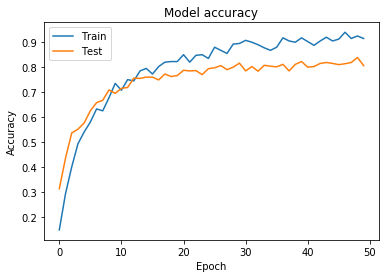

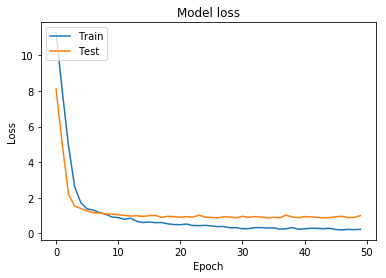

In [9]:
train_top_model_nn()

Train a SVM on computed VGG16 features of the database images

In [13]:
train_top_model_SVM()

['Precision SVM courante : acc = 13.0 acc_val = 12.375 C = 1e-06 gamma = 1e-08']
['Precision SVM courante : acc = 13.0 acc_val = 12.375 C = 1e-06 gamma = 1e-07']
['Precision SVM courante : acc = 13.0 acc_val = 12.375 C = 1e-06 gamma = 1e-06']
['Precision SVM courante : acc = 13.0 acc_val = 12.375 C = 1e-06 gamma = 1e-05']
['Precision SVM courante : acc = 13.0 acc_val = 12.375 C = 1e-06 gamma = 0.0001']
['Precision SVM courante : acc = 13.0 acc_val = 12.375 C = 1e-06 gamma = 0.001']
['Precision SVM courante : acc = 13.0 acc_val = 12.375 C = 1e-06 gamma = 0.01']
['Precision SVM courante : acc = 13.0 acc_val = 12.375 C = 1e-06 gamma = 0.1']
['Precision SVM courante : acc = 13.0 acc_val = 12.375 C = 1e-06 gamma = 1']
['Precision SVM courante : acc = 13.0 acc_val = 12.375 C = 1e-06 gamma = 10']
['Precision SVM courante : acc = 13.0 acc_val = 12.375 C = 1e-06 gamma = 100']
['Precision SVM courante : acc = 13.0 acc_val = 12.375 C = 1e-06 gamma = 1000']
['Precision SVM courante : acc = 13.0 ac

['Precision SVM courante : acc = 100.0 acc_val = 12.375 C = 100 gamma = 1']
['Precision SVM courante : acc = 100.0 acc_val = 12.375 C = 100 gamma = 10']
['Precision SVM courante : acc = 100.0 acc_val = 12.375 C = 100 gamma = 100']
['Precision SVM courante : acc = 100.0 acc_val = 12.375 C = 100 gamma = 1000']
['Precision SVM courante : acc = 81.0 acc_val = 69.875 C = 1000 gamma = 1e-08']
['Precision SVM courante : acc = 92.25 acc_val = 82.25 C = 1000 gamma = 1e-07']
['Precision SVM courante : acc = 100.0 acc_val = 84.0 C = 1000 gamma = 1e-06']
['Precision SVM courante : acc = 100.0 acc_val = 83.25 C = 1000 gamma = 1e-05']
['Precision SVM courante : acc = 100.0 acc_val = 82.125 C = 1000 gamma = 0.0001']
['Precision SVM courante : acc = 100.0 acc_val = 45.5 C = 1000 gamma = 0.001']
['Precision SVM courante : acc = 100.0 acc_val = 12.375 C = 1000 gamma = 0.01']
['Precision SVM courante : acc = 100.0 acc_val = 12.375 C = 1000 gamma = 0.1']
['Precision SVM courante : acc = 100.0 acc_val = 12